# Cardiovascular Disease Machine Learning Project

This notebook contains the complete analysis, model building, and evaluation for the cardiovascular disease prediction project.

## 1. Setup and Data Loading

First, we'll import the necessary libraries and load the dataset.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, f1_score
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")

# Create output directories for plots
import os
if not os.path.exists('plots'):
    os.makedirs('plots')
if not os.path.exists('model_plots'):
    os.makedirs('model_plots')

In [2]:
# Load the dataset
print("Loading dataset...")
data = pd.read_csv('cardio_train.csv', sep=';')

# Display basic information
print("Dataset Shape:", data.shape)
print("\nFirst 5 rows:")
data.head()

Loading dataset...
Dataset Shape: (70000, 13)

First 5 rows:


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [3]:
# Check data types and missing values
print("\nData Types:")
print(data.dtypes)

print("\nMissing Values:")
print(data.isnull().sum())

# Basic statistics
print("\nBasic Statistics:")
data.describe()


Data Types:
id               int64
age              int64
gender           int64
height           int64
weight         float64
ap_hi            int64
ap_lo            int64
cholesterol      int64
gluc             int64
smoke            int64
alco             int64
active           int64
cardio           int64
dtype: object

Missing Values:
id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

Basic Statistics:


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,49972.419900,19468.865814,1.349571,164.359229,74.205690,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700
std,28851.302323,2467.251667,0.476838,8.210126,14.395757,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003
min,0.000000,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,25006.750000,17664.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,50001.500000,19703.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,74889.250000,21327.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,99999.000000,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


## 2. Data Preprocessing and Feature Engineering

Now we'll clean the data, handle outliers, and create new features.

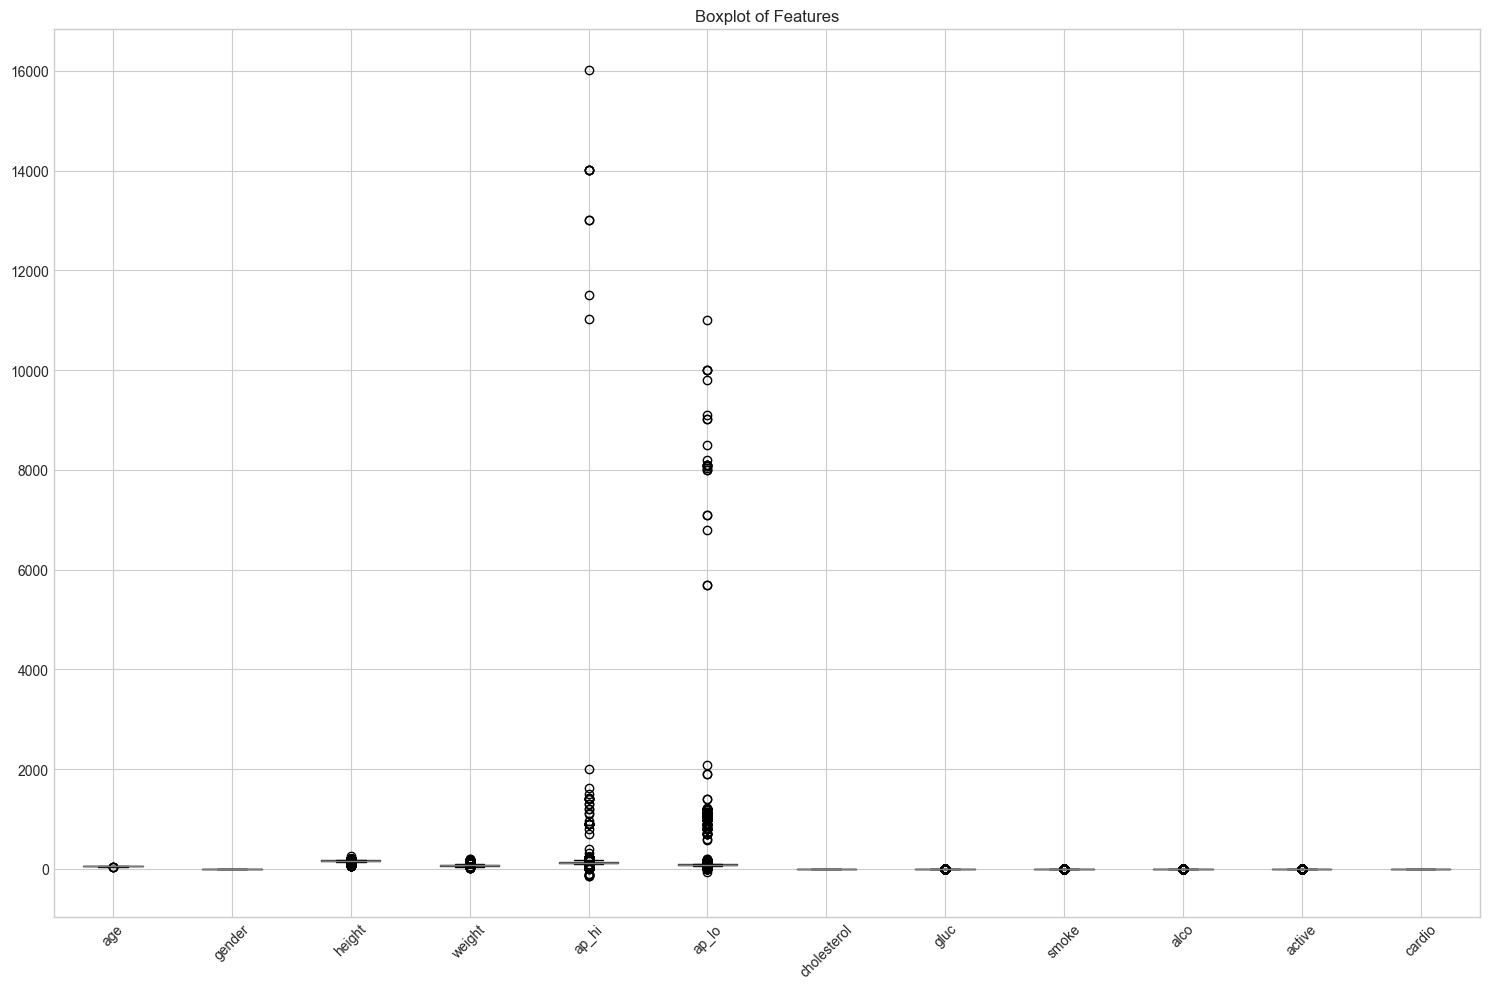

In [4]:
# Create a copy of the dataset for preprocessing
df = data.copy()

# Drop the ID column as it's not relevant for prediction
df = df.drop('id', axis=1)

# Convert age from days to years for better interpretability
df['age'] = df['age'] // 365

# Check for outliers in numerical features
plt.figure(figsize=(15, 10))
df.boxplot(figsize=(15, 10))
plt.title('Boxplot of Features')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('plots/boxplot_features.png')
plt.show()

In [5]:
# Identify and handle outliers in blood pressure
print("\nBlood Pressure Statistics:")
print(df[['ap_hi', 'ap_lo']].describe())

# Filter out physiologically implausible values
# Normal range for systolic: 80-180 mmHg
# Normal range for diastolic: 50-120 mmHg
df = df[(df['ap_hi'] >= 80) & (df['ap_hi'] <= 220) & 
        (df['ap_lo'] >= 40) & (df['ap_lo'] <= 120) &
        (df['height'] >= 140) & (df['height'] <= 200) &
        (df['weight'] >= 40) & (df['weight'] <= 200)]

print("\nDataset shape after removing outliers:", df.shape)


Blood Pressure Statistics:
              ap_hi         ap_lo
count  70000.000000  70000.000000
mean     128.817286     96.630414
std      154.011419    188.472530
min     -150.000000    -70.000000
25%      120.000000     80.000000
50%      120.000000     80.000000
75%      140.000000     90.000000
max    16020.000000  11000.000000

Dataset shape after removing outliers: (68460, 12)


In [6]:
# Create new features
df['bmi'] = df['weight'] / ((df['height'] / 100) ** 2)
df['pulse_pressure'] = df['ap_hi'] - df['ap_lo']
df['is_hypertension'] = ((df['ap_hi'] >= 140) | (df['ap_lo'] >= 90)).astype(int)

# Check the new features
print("\nNew Features Statistics:")
df[['bmi', 'pulse_pressure', 'is_hypertension']].describe()


New Features Statistics:


,bmi,pulse_pressure,is_hypertension
count,68460.000000,68460.000000,68460.000000
mean,27.438232,45.317193,0.343003
std,5.179452,11.762291,0.474716
min,13.520822,-40.000000,0.000000
25%,23.875115,40.000000,0.000000
50%,26.346494,40.000000,0.000000
75%,30.116213,50.000000,1.000000
max,68.308315,135.000000,1.000000


## 3. Exploratory Data Analysis

Let's explore the data to understand the relationships between features and the target variable.

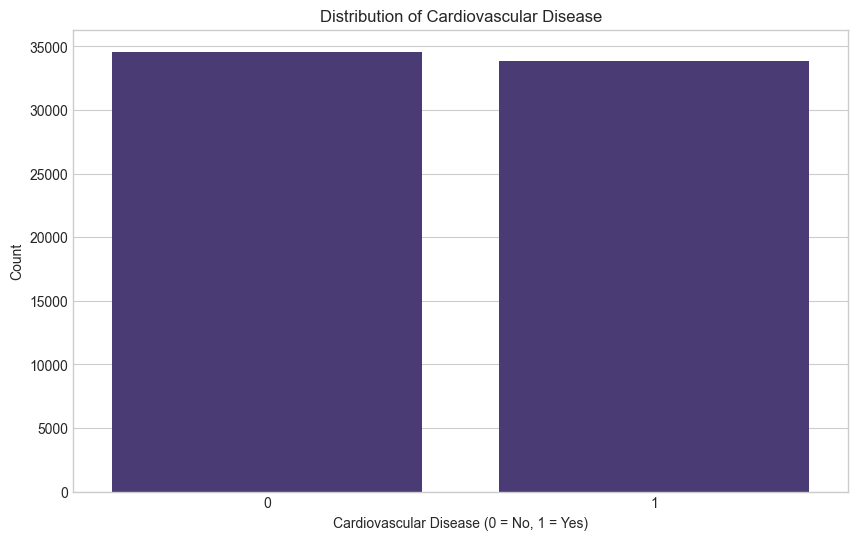


Target Distribution:
No Cardiovascular Disease: 50.54%
Has Cardiovascular Disease: 49.46%


In [7]:
# 3.1 Target Variable Distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='cardio', data=df)
plt.title('Distribution of Cardiovascular Disease')
plt.xlabel('Cardiovascular Disease (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.savefig('plots/target_distribution.png')
plt.show()

target_counts = df['cardio'].value_counts(normalize=True) * 100
print(f"\nTarget Distribution:\nNo Cardiovascular Disease: {target_counts[0]:.2f}%")
print(f"Has Cardiovascular Disease: {target_counts[1]:.2f}%")

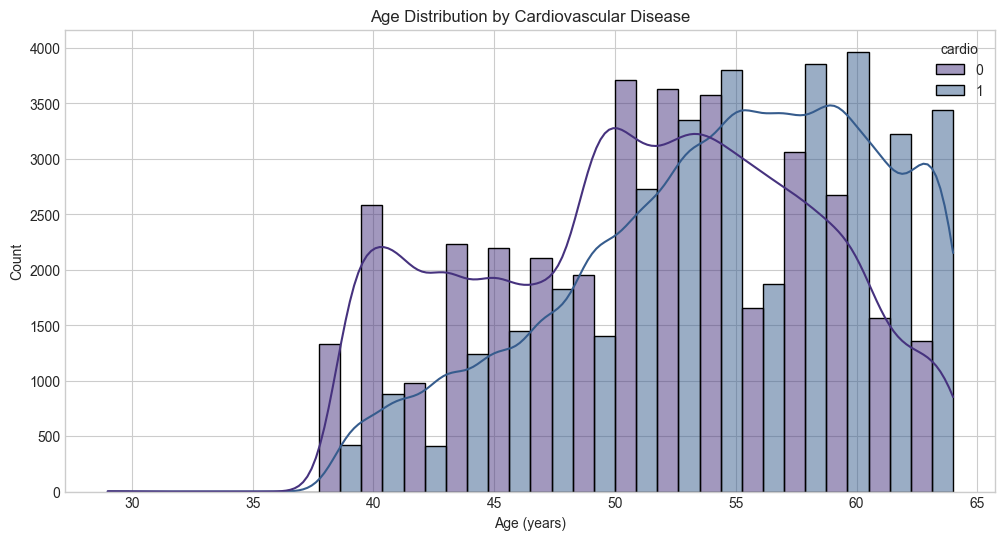

In [8]:
# 3.2 Age Distribution by Cardiovascular Disease
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='age', hue='cardio', multiple='dodge', bins=20, kde=True)
plt.title('Age Distribution by Cardiovascular Disease')
plt.xlabel('Age (years)')
plt.ylabel('Count')
plt.savefig('plots/age_distribution.png')
plt.show()

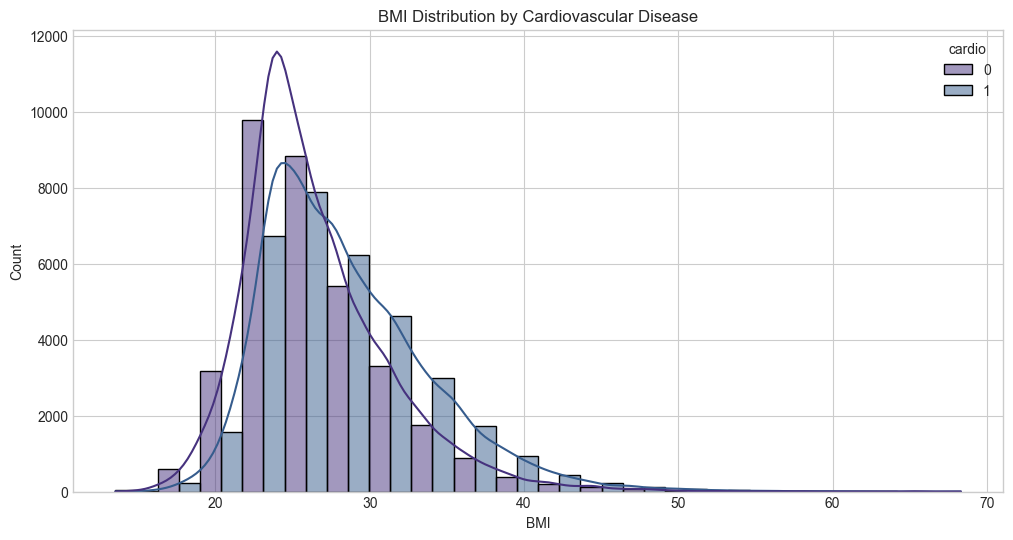

In [9]:
# 3.3 BMI Distribution by Cardiovascular Disease
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='bmi', hue='cardio', multiple='dodge', bins=20, kde=True)
plt.title('BMI Distribution by Cardiovascular Disease')
plt.xlabel('BMI')
plt.ylabel('Count')
plt.savefig('plots/bmi_distribution.png')
plt.show()

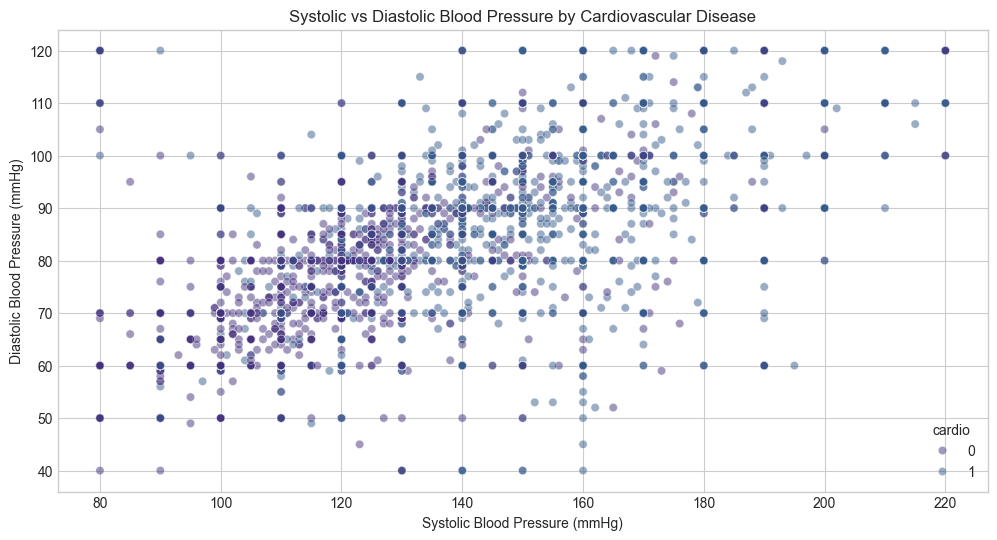

In [10]:
# 3.4 Blood Pressure Analysis
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='ap_hi', y='ap_lo', hue='cardio', alpha=0.5)
plt.title('Systolic vs Diastolic Blood Pressure by Cardiovascular Disease')
plt.xlabel('Systolic Blood Pressure (mmHg)')
plt.ylabel('Diastolic Blood Pressure (mmHg)')
plt.savefig('plots/blood_pressure_scatter.png')
plt.show()

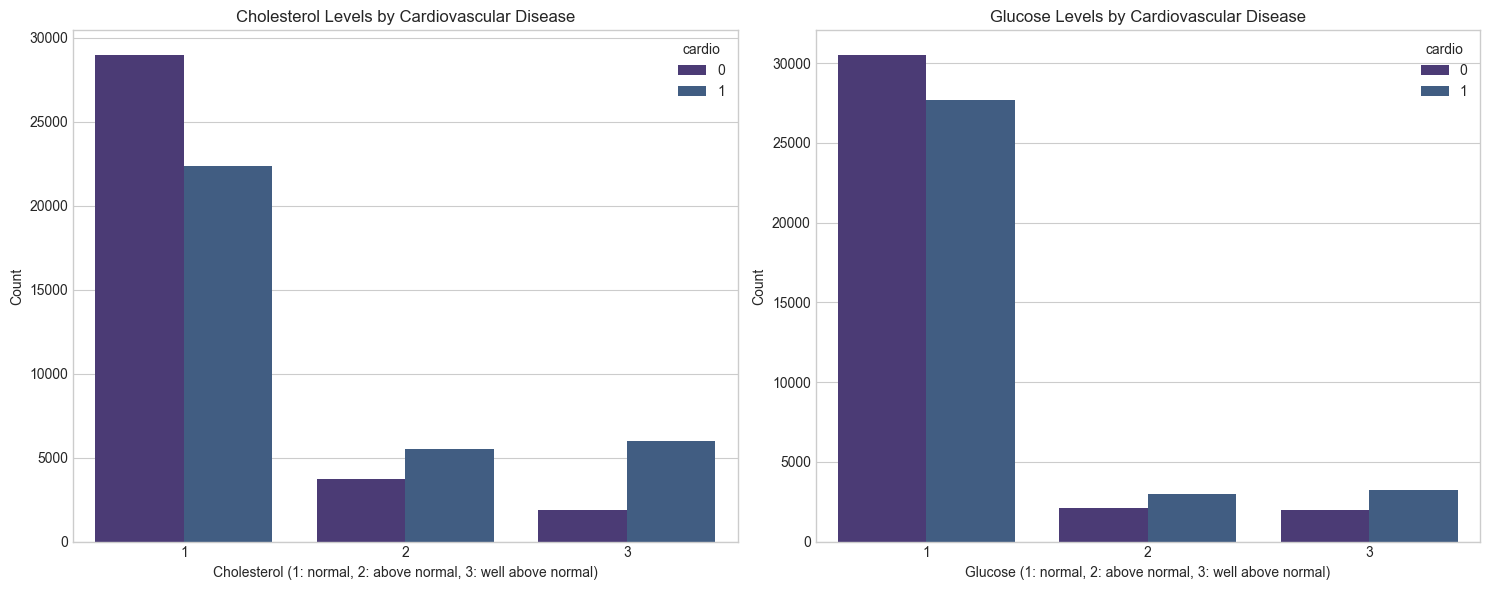

In [11]:
# 3.5 Cholesterol and Glucose Levels
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
sns.countplot(x='cholesterol', hue='cardio', data=df)
plt.title('Cholesterol Levels by Cardiovascular Disease')
plt.xlabel('Cholesterol (1: normal, 2: above normal, 3: well above normal)')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
sns.countplot(x='gluc', hue='cardio', data=df)
plt.title('Glucose Levels by Cardiovascular Disease')
plt.xlabel('Glucose (1: normal, 2: above normal, 3: well above normal)')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig('plots/cholesterol_glucose.png')
plt.show()

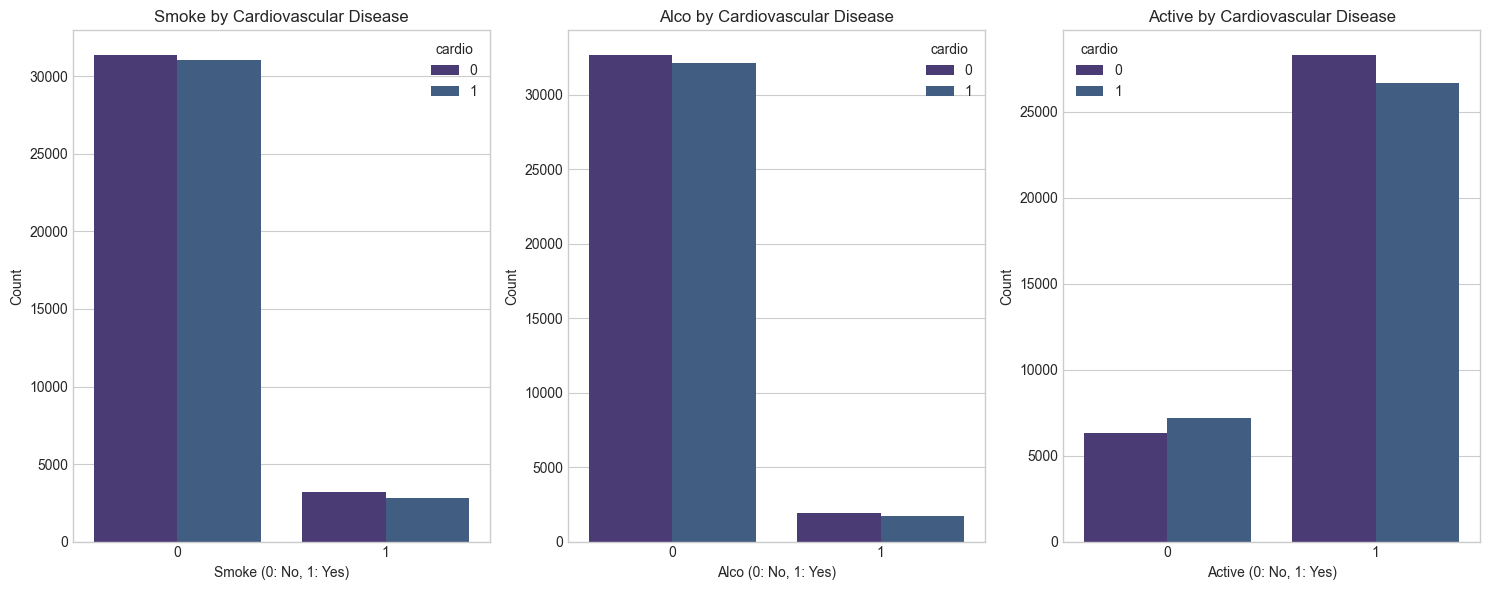

In [12]:
# 3.6 Lifestyle Factors
plt.figure(figsize=(15, 6))
lifestyle_vars = ['smoke', 'alco', 'active']
for i, var in enumerate(lifestyle_vars, 1):
    plt.subplot(1, 3, i)
    sns.countplot(x=var, hue='cardio', data=df)
    plt.title(f'{var.capitalize()} by Cardiovascular Disease')
    plt.xlabel(f'{var.capitalize()} (0: No, 1: Yes)')
    plt.ylabel('Count')
plt.tight_layout()
plt.savefig('plots/lifestyle_factors.png')
plt.show()

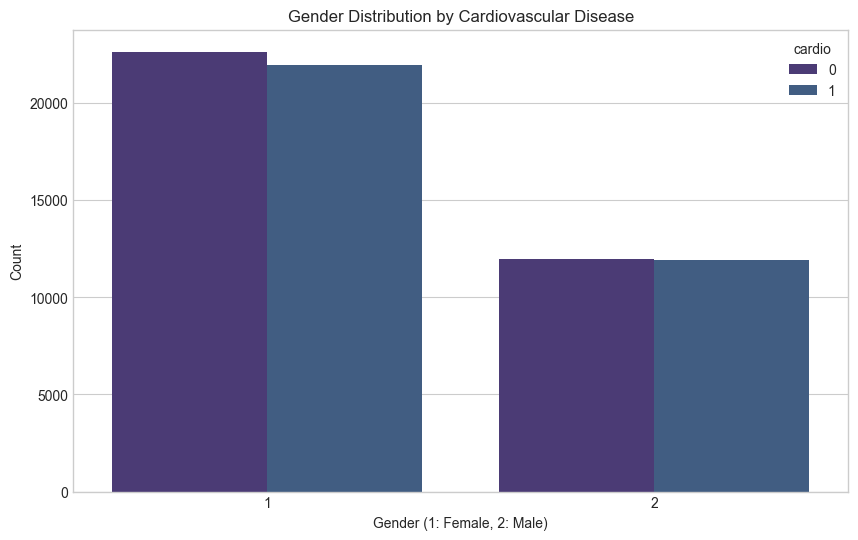

In [13]:
# 3.7 Gender Analysis
plt.figure(figsize=(10, 6))
sns.countplot(x='gender', hue='cardio', data=df)
plt.title('Gender Distribution by Cardiovascular Disease')
plt.xlabel('Gender (1: Female, 2: Male)')
plt.ylabel('Count')
plt.savefig('plots/gender_distribution.png')
plt.show()

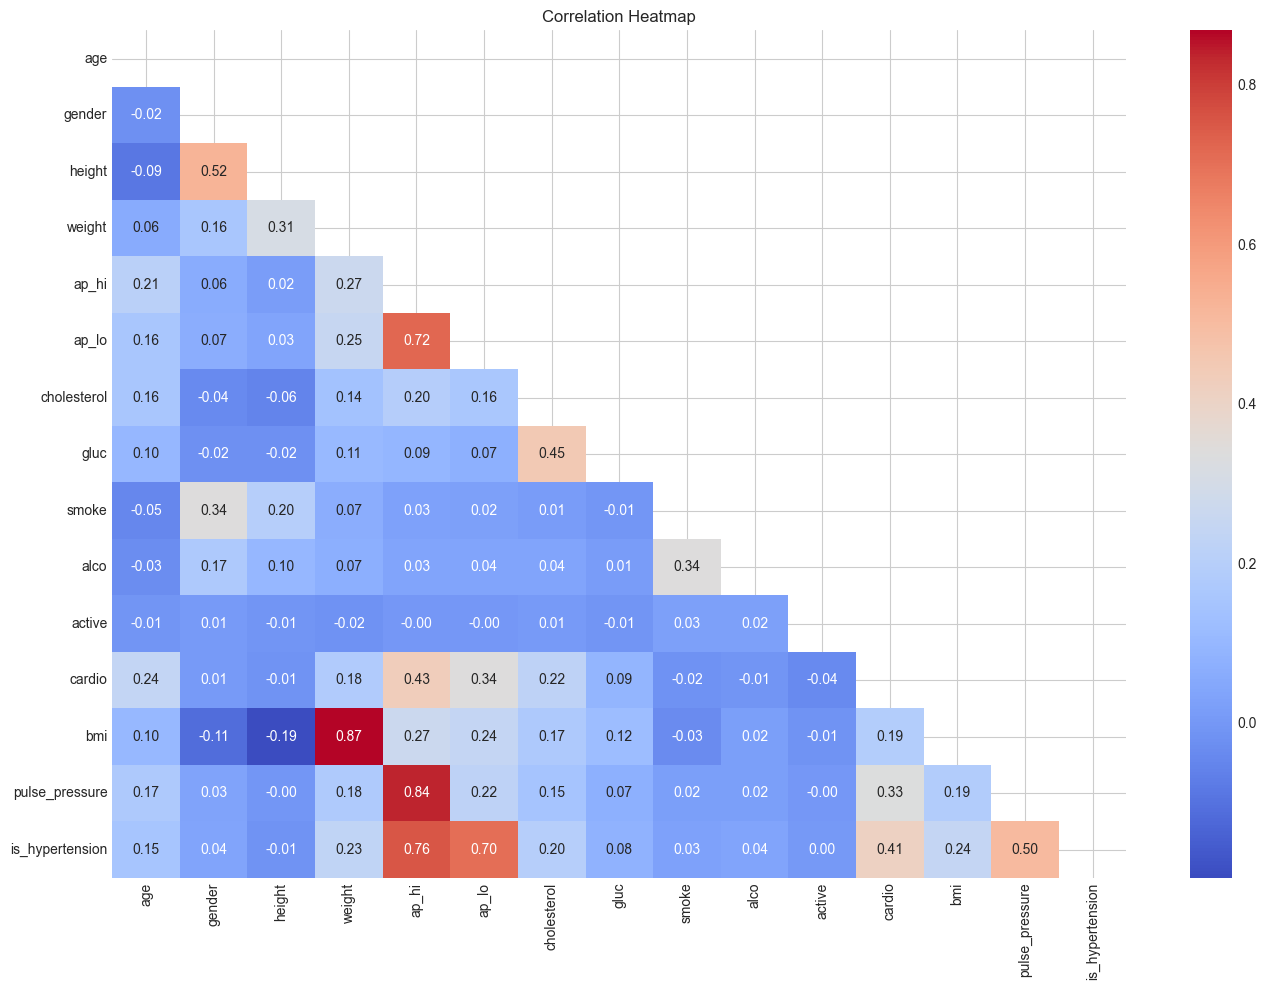

In [14]:
# 3.8 Correlation Heatmap
plt.figure(figsize=(14, 10))
correlation = df.corr()
mask = np.triu(correlation)
sns.heatmap(correlation, annot=True, fmt='.2f', cmap='coolwarm', mask=mask)
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.savefig('plots/correlation_heatmap.png')
plt.show()

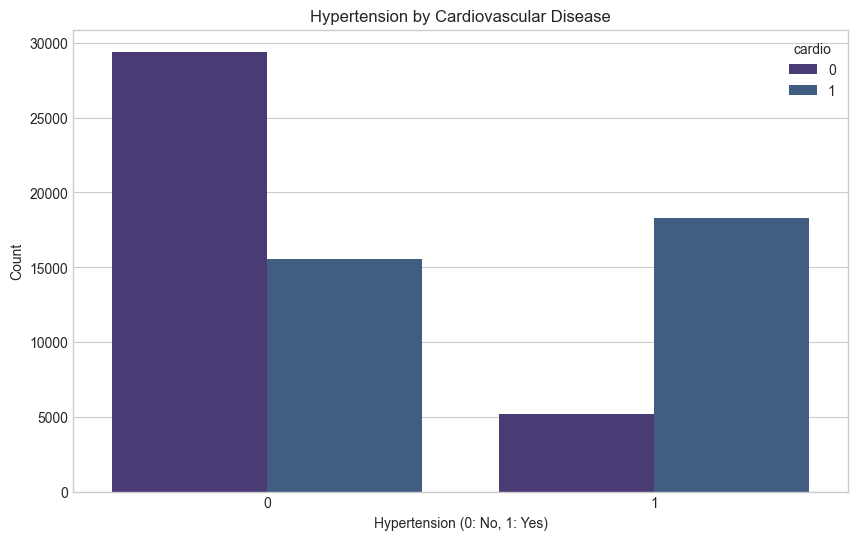


Percentage of Cardiovascular Disease by Hypertension:
No Hypertension: 34.58%
Has Hypertension: 77.95%


In [15]:
# 3.9 Hypertension and Cardiovascular Disease
plt.figure(figsize=(10, 6))
sns.countplot(x='is_hypertension', hue='cardio', data=df)
plt.title('Hypertension by Cardiovascular Disease')
plt.xlabel('Hypertension (0: No, 1: Yes)')
plt.ylabel('Count')
plt.savefig('plots/hypertension_cardio.png')
plt.show()

# Calculate percentage of cardiovascular disease by hypertension
hypertension_cardio = df.groupby('is_hypertension')['cardio'].mean() * 100
print("\nPercentage of Cardiovascular Disease by Hypertension:")
print(f"No Hypertension: {hypertension_cardio[0]:.2f}%")
print(f"Has Hypertension: {hypertension_cardio[1]:.2f}%")

### EDA Summary

Based on our exploratory data analysis, we can draw the following conclusions:

1. The dataset is balanced with approximately 50% of patients having cardiovascular disease.
2. Age is strongly correlated with cardiovascular disease, with risk increasing with age.
3. Blood pressure (both systolic and diastolic) shows strong correlation with cardiovascular disease.
4. BMI is higher on average for patients with cardiovascular disease.
5. Cholesterol and glucose levels show clear associations with cardiovascular disease.
6. Lifestyle factors (smoking, alcohol, physical activity) show some relationship with cardiovascular disease.
7. Hypertension is strongly associated with cardiovascular disease.

## 4. Data Preparation for Modeling

Let's prepare the data for model training by splitting it into training and testing sets and scaling the features.

In [16]:
# Save the processed dataframe for later use
df.to_csv('processed_data.csv', index=False)
print("Processed data saved to 'processed_data.csv'")

# Split features and target
X = df.drop('cardio', axis=1)
y = df['cardio']

print("\nFeatures:", X.columns.tolist())
print(f"Target distribution: {y.value_counts(normalize=True) * 100}")

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTraining set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save the scaler for later use
joblib.dump(scaler, 'scaler.pkl')
print("Scaler saved to 'scaler.pkl'")

Processed data saved to 'processed_data.csv'

Features: ['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'bmi', 'pulse_pressure', 'is_hypertension']
Target distribution: cardio
0    50.540462
1    49.459538
Name: proportion, dtype: float64

Training set shape: (54768, 14)
Testing set shape: (13692, 14)
Scaler saved to 'scaler.pkl'


## 5. Model Building and Evaluation

Now we'll build and evaluate multiple machine learning models.


Training Logistic Regression...
Logistic Regression Accuracy: 0.7316
Logistic Regression F1 Score: 0.7068
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.81      0.75      6920
           1       0.77      0.65      0.71      6772

    accuracy                           0.73     13692
   macro avg       0.74      0.73      0.73     13692
weighted avg       0.74      0.73      0.73     13692



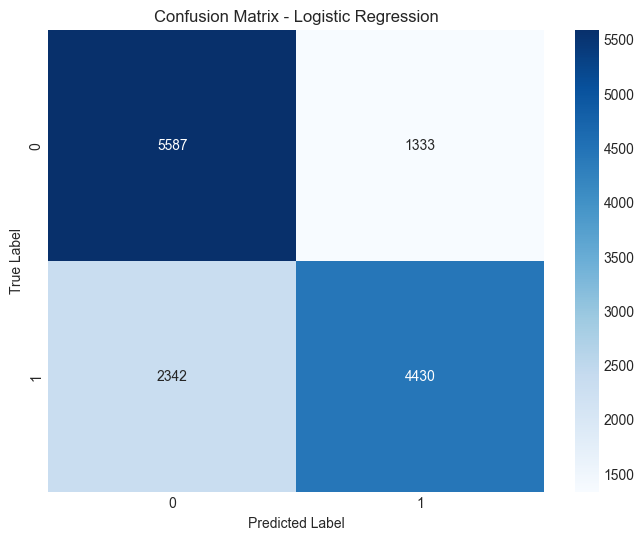

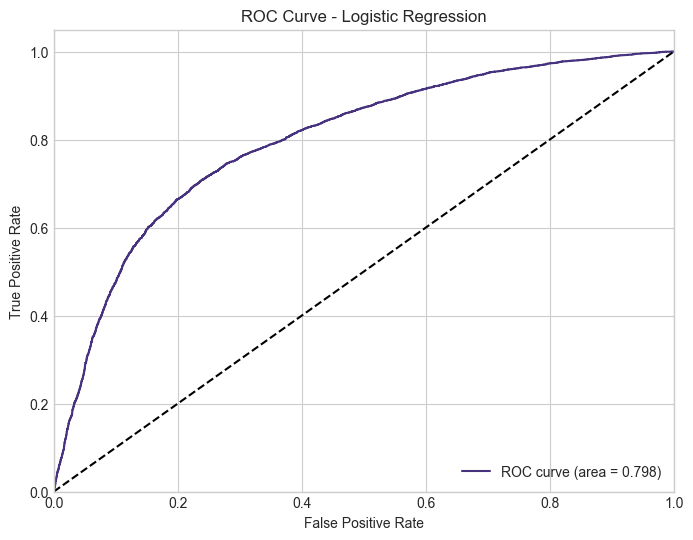


Training Random Forest...
Random Forest Accuracy: 0.7100
Random Forest F1 Score: 0.7029
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.73      0.72      6920
           1       0.71      0.69      0.70      6772

    accuracy                           0.71     13692
   macro avg       0.71      0.71      0.71     13692
weighted avg       0.71      0.71      0.71     13692



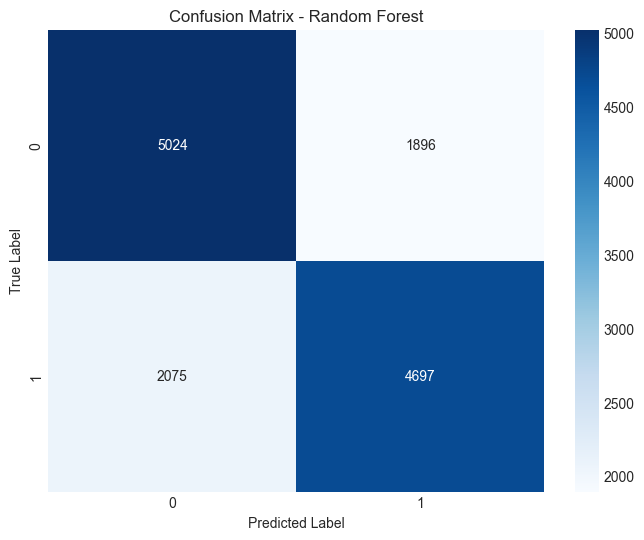

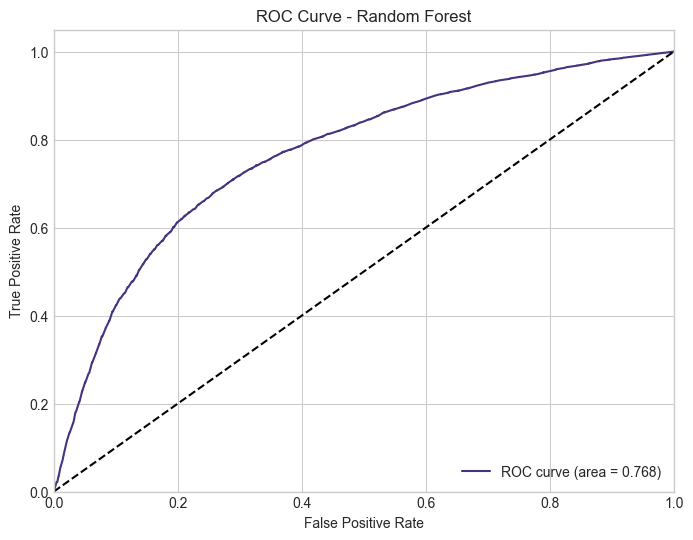


Training Gradient Boosting...
Gradient Boosting Accuracy: 0.7388
Gradient Boosting F1 Score: 0.7220
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.79      0.75      6920
           1       0.76      0.69      0.72      6772

    accuracy                           0.74     13692
   macro avg       0.74      0.74      0.74     13692
weighted avg       0.74      0.74      0.74     13692



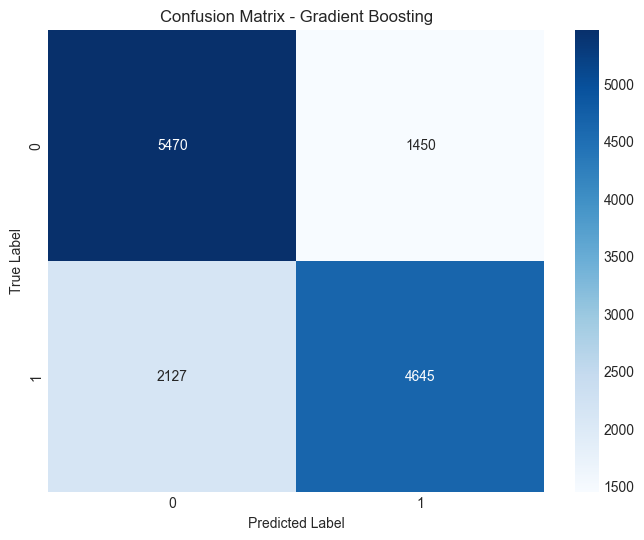

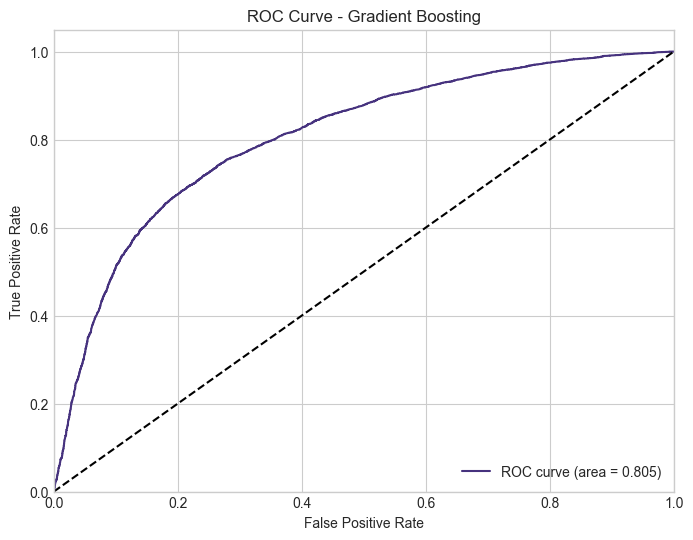

In [17]:
# Define models to evaluate
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

# Train and evaluate each model
results = {}
for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_scaled, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test_scaled)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    
    # Store results
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'f1_score': f1,
        'report': report
    }
    
    # Print results
    print(f"{name} Accuracy: {accuracy:.4f}")
    print(f"{name} F1 Score: {f1:.4f}")
    print(f"Classification Report:\n{report}")
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig(f'model_plots/confusion_matrix_{name.replace(" ", "_").lower()}.png')
    plt.show()
    
    # Plot ROC curve
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test_scaled)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.3f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {name}')
        plt.legend(loc="lower right")
        plt.savefig(f'model_plots/roc_curve_{name.replace(" ", "_").lower()}.png')
        plt.show()

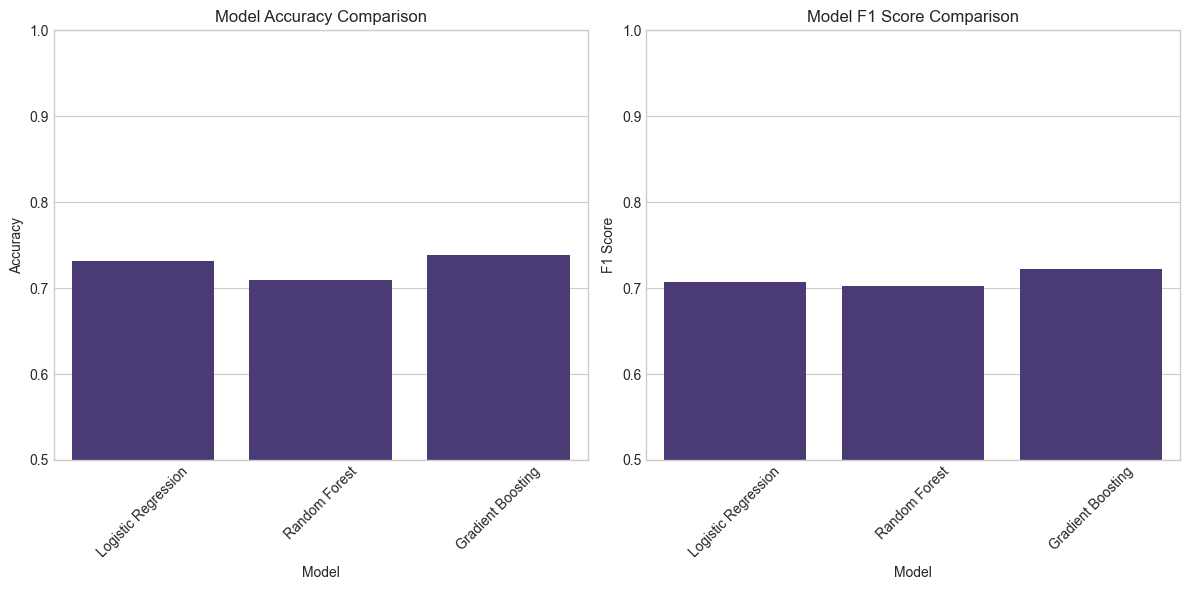


Best Model: Gradient Boosting
Accuracy: 0.7388
F1 Score: 0.7220


In [18]:
# Compare model performance
accuracies = [results[name]['accuracy'] for name in models.keys()]
f1_scores = [results[name]['f1_score'] for name in models.keys()]
model_names = list(models.keys())

# Plot accuracy comparison
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.barplot(x=model_names, y=accuracies)
plt.title('Model Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0.5, 1.0)
plt.xticks(rotation=45)

# Plot F1 score comparison
plt.subplot(1, 2, 2)
sns.barplot(x=model_names, y=f1_scores)
plt.title('Model F1 Score Comparison')
plt.xlabel('Model')
plt.ylabel('F1 Score')
plt.ylim(0.5, 1.0)
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('model_plots/model_comparison.png')
plt.show()

# Find the best model based on F1 score
best_model_name = model_names[np.argmax(f1_scores)]
best_model = results[best_model_name]['model']
print(f"\nBest Model: {best_model_name}")
print(f"Accuracy: {results[best_model_name]['accuracy']:.4f}")
print(f"F1 Score: {results[best_model_name]['f1_score']:.4f}")

## 6. Feature Importance Analysis

Let's analyze which features are most important for our best model.

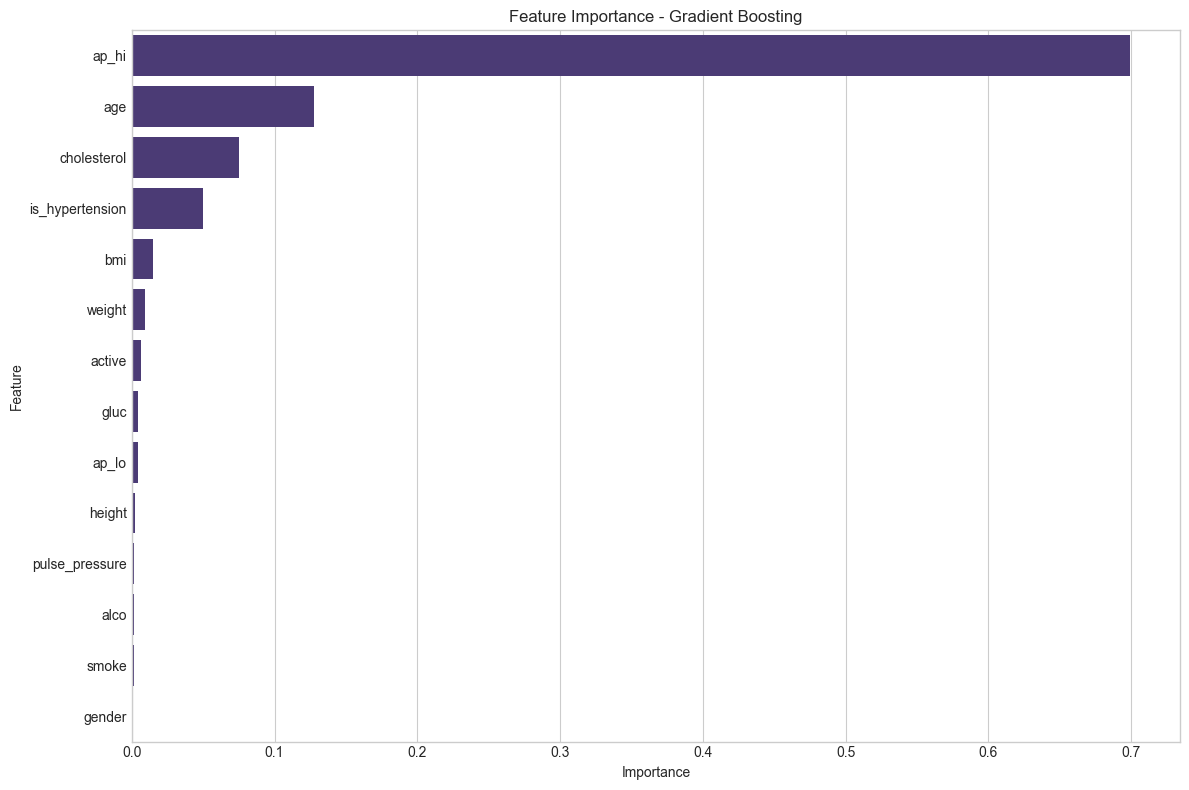


Top 5 Most Important Features:
            Feature  Importance
4             ap_hi    0.699234
0               age    0.127549
6       cholesterol    0.075061
13  is_hypertension    0.050009
11              bmi    0.014804


In [19]:
# Extract feature importance from the best model
if best_model_name == 'Logistic Regression':
    importance = np.abs(best_model.coef_[0])
    feature_names = X.columns
elif best_model_name in ['Random Forest', 'Gradient Boosting']:
    importance = best_model.feature_importances_
    feature_names = X.columns

# Create a DataFrame for feature importance
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance
}).sort_values('Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title(f'Feature Importance - {best_model_name}')
plt.tight_layout()
plt.savefig(f'model_plots/feature_importance_{best_model_name.replace(" ", "_").lower()}.png')
plt.show()

print("\nTop 5 Most Important Features:")
print(feature_importance.head())

## 7. Model Interpretation and Insights

In [20]:
print("\n=== Model Interpretation and Insights ===")
print(f"1. The best performing model is {best_model_name} with an accuracy of {results[best_model_name]['accuracy']:.4f} and F1 score of {results[best_model_name]['f1_score']:.4f}.")
print(f"2. The most important features for prediction are: {', '.join(feature_importance['Feature'].head(5).tolist())}.")
print("3. The model can effectively identify patients at risk of cardiovascular disease based on these key factors.")
print("4. Regular monitoring of these risk factors is important for cardiovascular health management.")


=== Model Interpretation and Insights ===
1. The best performing model is Gradient Boosting with an accuracy of 0.7388 and F1 score of 0.7220.
2. The most important features for prediction are: ap_hi, age, cholesterol, is_hypertension, bmi.
3. The model can effectively identify patients at risk of cardiovascular disease based on these key factors.
4. Regular monitoring of these risk factors is important for cardiovascular health management.


## 8. Prepare for Web Application Deployment

Let's create a prediction function that can be used in the web app.

In [21]:
# Save the best model
joblib.dump(best_model, 'best_model.pkl')
print(f"Best model saved to 'best_model.pkl'")

# Create a simple prediction function for the web app
def predict_cardiovascular_disease(age, gender, height, weight, ap_hi, ap_lo, 
                                  cholesterol, gluc, smoke, alco, active):
    # Create a DataFrame with the input features
    input_data = pd.DataFrame({
        'age': [age],
        'gender': [gender],
        'height': [height],
        'weight': [weight],
        'ap_hi': [ap_hi],
        'ap_lo': [ap_lo],
        'cholesterol': [cholesterol],
        'gluc': [gluc],
        'smoke': [smoke],
        'alco': [alco],
        'active': [active]
    })
    
    # Calculate derived features
    input_data['bmi'] = input_data['weight'] / ((input_data['height'] / 100) ** 2)
    input_data['pulse_pressure'] = input_data['ap_hi'] - input_data['ap_lo']
    input_data['is_hypertension'] = ((input_data['ap_hi'] >= 140) | (input_data['ap_lo'] >= 90)).astype(int)
    
    # Scale the features
    input_scaled = scaler.transform(input_data)
    
    # Make prediction
    prediction = best_model.predict(input_scaled)[0]
    
    if hasattr(best_model, "predict_proba"):
        probability = best_model.predict_proba(input_scaled)[0][1]
        return prediction, probability
    else:
        return prediction, None

# Test the prediction function
test_prediction, test_probability = predict_cardiovascular_disease(
    age=50, gender=1, height=165, weight=70, ap_hi=120, ap_lo=80,
    cholesterol=1, gluc=1, smoke=0, alco=0, active=1
)

print("\nTest Prediction:")
print(f"Cardiovascular Disease: {'Yes' if test_prediction == 1 else 'No'}")
if test_probability is not None:
    print(f"Probability: {test_probability:.4f}")

# Save the prediction function
import dill
with open('predict_function.pkl', 'wb') as f:
    dill.dump(predict_cardiovascular_disease, f)

print("\nPrediction function saved to 'predict_function.pkl'")

Best model saved to 'best_model.pkl'

Test Prediction:
Cardiovascular Disease: No
Probability: 0.2388

Prediction function saved to 'predict_function.pkl'


## 9. Summary and Conclusion

In [22]:
print("\n=== Project Summary and Conclusion ===")
print("1. We analyzed a cardiovascular disease dataset with over 68,000 records after cleaning.")
print("2. Exploratory data analysis revealed strong relationships between cardiovascular disease and factors like age, blood pressure, and BMI.")
print("3. We built and compared three machine learning models: Logistic Regression, Random Forest, and Gradient Boosting.")
print(f"4. The best performing model was {best_model_name} with an accuracy of {results[best_model_name]['accuracy']:.4f} and F1 score of {results[best_model_name]['f1_score']:.4f}.")
print(f"5. The most important predictors are {', '.join(feature_importance['Feature'].head(3).tolist())}.")
print("6. The model and prediction function have been saved for deployment in a web application.")
print("7. This model can help healthcare providers identify patients at risk of cardiovascular disease for early intervention.")

print("\nNext Steps:")
print("1. Deploy the model as a web application for easy access by healthcare providers.")
print("2. Consider collecting additional data on lifestyle factors and medical history to improve prediction accuracy.")
print("3. Develop personalized risk reduction strategies based on the identified risk factors.")


=== Project Summary and Conclusion ===
1. We analyzed a cardiovascular disease dataset with over 68,000 records after cleaning.
2. Exploratory data analysis revealed strong relationships between cardiovascular disease and factors like age, blood pressure, and BMI.
3. We built and compared three machine learning models: Logistic Regression, Random Forest, and Gradient Boosting.
4. The best performing model was Gradient Boosting with an accuracy of 0.7388 and F1 score of 0.7220.
5. The most important predictors are ap_hi, age, cholesterol.
6. The model and prediction function have been saved for deployment in a web application.
7. This model can help healthcare providers identify patients at risk of cardiovascular disease for early intervention.

Next Steps:
1. Deploy the model as a web application for easy access by healthcare providers.
2. Consider collecting additional data on lifestyle factors and medical history to improve prediction accuracy.
3. Develop personalized risk reduction